In [91]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import seaborn as sns


csv_path = './snapshots/20240829-010954-day73_all_stocks.csv'
df = pd.read_csv(csv_path)
match = re.search(r'(\d{8}-\d{6})-day(\d+)', csv_path)
day = 0
timestamp = 0
if match:
    timestamp = match.group(1)
    day = match.group(2)
    print(f"Timestamp: {timestamp}")
    print(f"Day: {day}")
else:
    print("No timestamp or day information found")

Timestamp: 20240829-010954
Day: 73


In [92]:
def pre_processing(df):
    df['MidPrice'] = (df['AskPrice1'] * df['AskVolume1'] + df['BidPrice1'] * df['BidVolume1']) / (df['AskVolume1'] + df['BidVolume1'])
    df['position_change'] = df.groupby('StockID')['share_holding'].diff()
    df['ticks_since_last_change'] = df.groupby('StockID').apply(lambda x: x['Tick'] - x['Tick'].where(x['position_change'] != 0).ffill()).reset_index(level=0, drop=True)
    return df

def calculate_vwap(df):
    df['CumulativeVolume'] = df['TotalTradeVolume'].cumsum()
    df['CumulativeValue'] = df['TotalTradeValue'].cumsum()
    df['VWAP'] = df['CumulativeValue'] / df['CumulativeVolume']
    return df

def plot_all_stocks_with_vwap(df, output_folder='stock_plots'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    df = df.groupby('StockID').apply(calculate_vwap).reset_index(drop=True)

    for stock_id in df['StockID'].unique():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f'Stock {stock_id}: Price, VWAP, and Trading Activity', fontsize=16)
        
        stock_data = df[df['StockID'] == stock_id]
        
        # Plot price and VWAP
        ax1.plot(stock_data['Tick'], stock_data['MidPrice'], label='Mid Price', color='b', linewidth=1.5)
        ax1.plot(stock_data['Tick'], stock_data['VWAP'], label='VWAP', color='g', linestyle='--', linewidth=1.5)
        ax1.fill_between(stock_data['Tick'], stock_data['BidPrice1'], stock_data['AskPrice1'], 
                         alpha=0.2, color='gray', label='Bid-Ask Spread')
        
        ax1.set_ylabel('Price', fontsize=12)
        ax1.tick_params(axis='y', labelsize=10)
        
        # Set y-axis limits for price plot
        price_range = stock_data['MidPrice'].max() - stock_data['MidPrice'].min()
        ax1.set_ylim(stock_data['MidPrice'].min() - price_range*0.1, 
                     stock_data['MidPrice'].max() + price_range*0.1)
        
        # Mark points where trading occurred
        buys = stock_data[stock_data['position_change'] > 0]
        sells = stock_data[stock_data['position_change'] < 0]
        ax1.scatter(buys['Tick'], buys['MidPrice'], color='g', s=50, label='Buy', marker='^', zorder=5)
        ax1.scatter(sells['Tick'], sells['MidPrice'], color='r', s=50, label='Sell', marker='v', zorder=5)
        
        ax1.legend(fontsize=10, loc='upper left')
        
        # Plot share holding and target volume
        ax2.plot(stock_data['Tick'], stock_data['share_holding'], color='b', alpha=0.7, label='Share Holding', linewidth=1.5)
        ax2.plot(stock_data['Tick'], stock_data['target_volume'], color='m', alpha=0.7, label='Target Volume', linewidth=1.5)
        ax2.set_ylabel('Volume', fontsize=12)
        ax2.tick_params(axis='y', labelsize=10)
        
        # Plot trade volume as bars
        trade_volume = stock_data['position_change'].abs()
        ax2.bar(stock_data['Tick'], trade_volume, alpha=0.3, color='g', label='Trade Volume')
        
        ax2.legend(fontsize=10, loc='upper left')
        
        ax2.set_xlabel('Tick', fontsize=12)
        ax2.tick_params(axis='x', labelsize=10)
        
        plt.tight_layout()
        
        filename = f'{stock_id}_plot.png'
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        print(f"Saved plot for {stock_id} to {filepath}")

In [93]:
df = pre_processing(df)
plot_all_stocks_with_vwap(df, f'./analysis/day{day}')

/var/folders/7v/0pft7_9d053gl9jmqh7tn0sr0000gn/T/ipykernel_39105/1258455958.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ticks_since_last_change'] = df.groupby('StockID').apply(lambda x: x['Tick'] - x['Tick'].where(x['position_change'] != 0).ffill()).reset_index(level=0, drop=True)
/var/folders/7v/0pft7_9d053gl9jmqh7tn0sr0000gn/T/ipykernel_39105/1258455958.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence thi

Saved plot for UBIQ000 to ./analysis/day73/UBIQ000_plot.png
Saved plot for UBIQ001 to ./analysis/day73/UBIQ001_plot.png
Saved plot for UBIQ002 to ./analysis/day73/UBIQ002_plot.png
Saved plot for UBIQ003 to ./analysis/day73/UBIQ003_plot.png
Saved plot for UBIQ004 to ./analysis/day73/UBIQ004_plot.png


In [ ]:
from PIL import Image
import os

def stitch_images(directory, output_file, columns=5):
    # 获取目录下所有图片文件
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 打开所有图片
    images = [Image.open(os.path.join(directory, f)) for f in image_files]
    
    # 计算行数
    rows = (len(images) + columns - 1) // columns
    
    # 获取单个图片的宽度和高度
    width, height = images[0].size
    
    # 创建新图片
    result = Image.new('RGB', (width * columns, height * rows))
    
    # 粘贴图片
    for idx, img in enumerate(images):
        x = (idx % columns) * width
        y = (idx // columns) * height
        result.paste(img, (x, y))
    
    # 保存结果
    result.save(os.path.join(output_file, output_file))

In [ ]:
stitch_images('./analysis/day56/', 'output.png', columns=5)

In [ ]:

def monitor_and_process(directory: str, process_func: Callable[[str], None], max_day: int = 80):
    """
    监控目录并处理文件
    
    Args:
    directory (str): 要监控的目录
    process_func (Callable[[str], None]): 处理文件的函数
    max_day (int): 最大天数，默认为80
    """
    last_day = 0
    pattern = re.compile(r'(\d{8}-\d{6})-day(\d+)_all_stocks\.csv')
    
    while last_day < max_day:
        files = os.listdir(directory)
        for file in files:
            match = pattern.match(file)
            if match:
                day_part = int(match.group(2))
                if day_part == last_day + 1:
                    if last_day > 0:  # 确保不会处理第0天的数据
                        last_day_file = next(f for f in files if f'-day{last_day}_' in f)
                        process_func(os.path.join(directory, last_day_file))
                    last_day = day_part
                    print(f"Moved to day {last_day}")
                    break  # 找到并处理了文件，退出内层循环
        time.sleep(60)  # 每分钟检查一次
    
    logger.info("Reached day 80. Processing complete.")

if __name__ == "__main__":
    directory = './snapshots'
    monitor_and_process(directory, process_day_data)
        match = pattern.match(file)
        if match:
            date_part = match.group(1)
            day_part = int(match.group(2))
            if day_part > last_day:
                last_day = day_part

/Users/xiachunxuan/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xiachunxuan/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/7v/0pft7_9d053gl9jmqh7tn0sr0000gn/T/ipykernel_57745/90993431.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = df.groupby('StockID').apply(analyze_correlation)


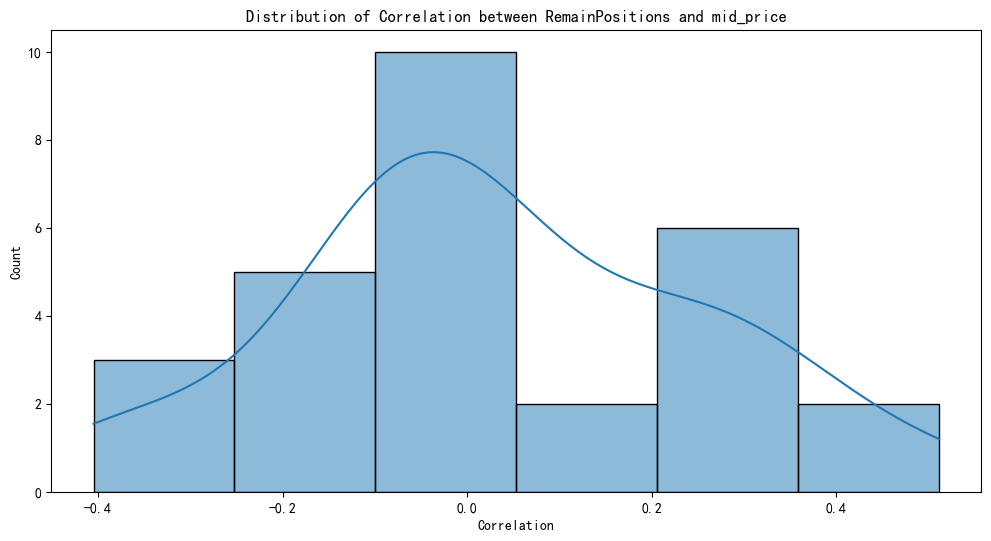

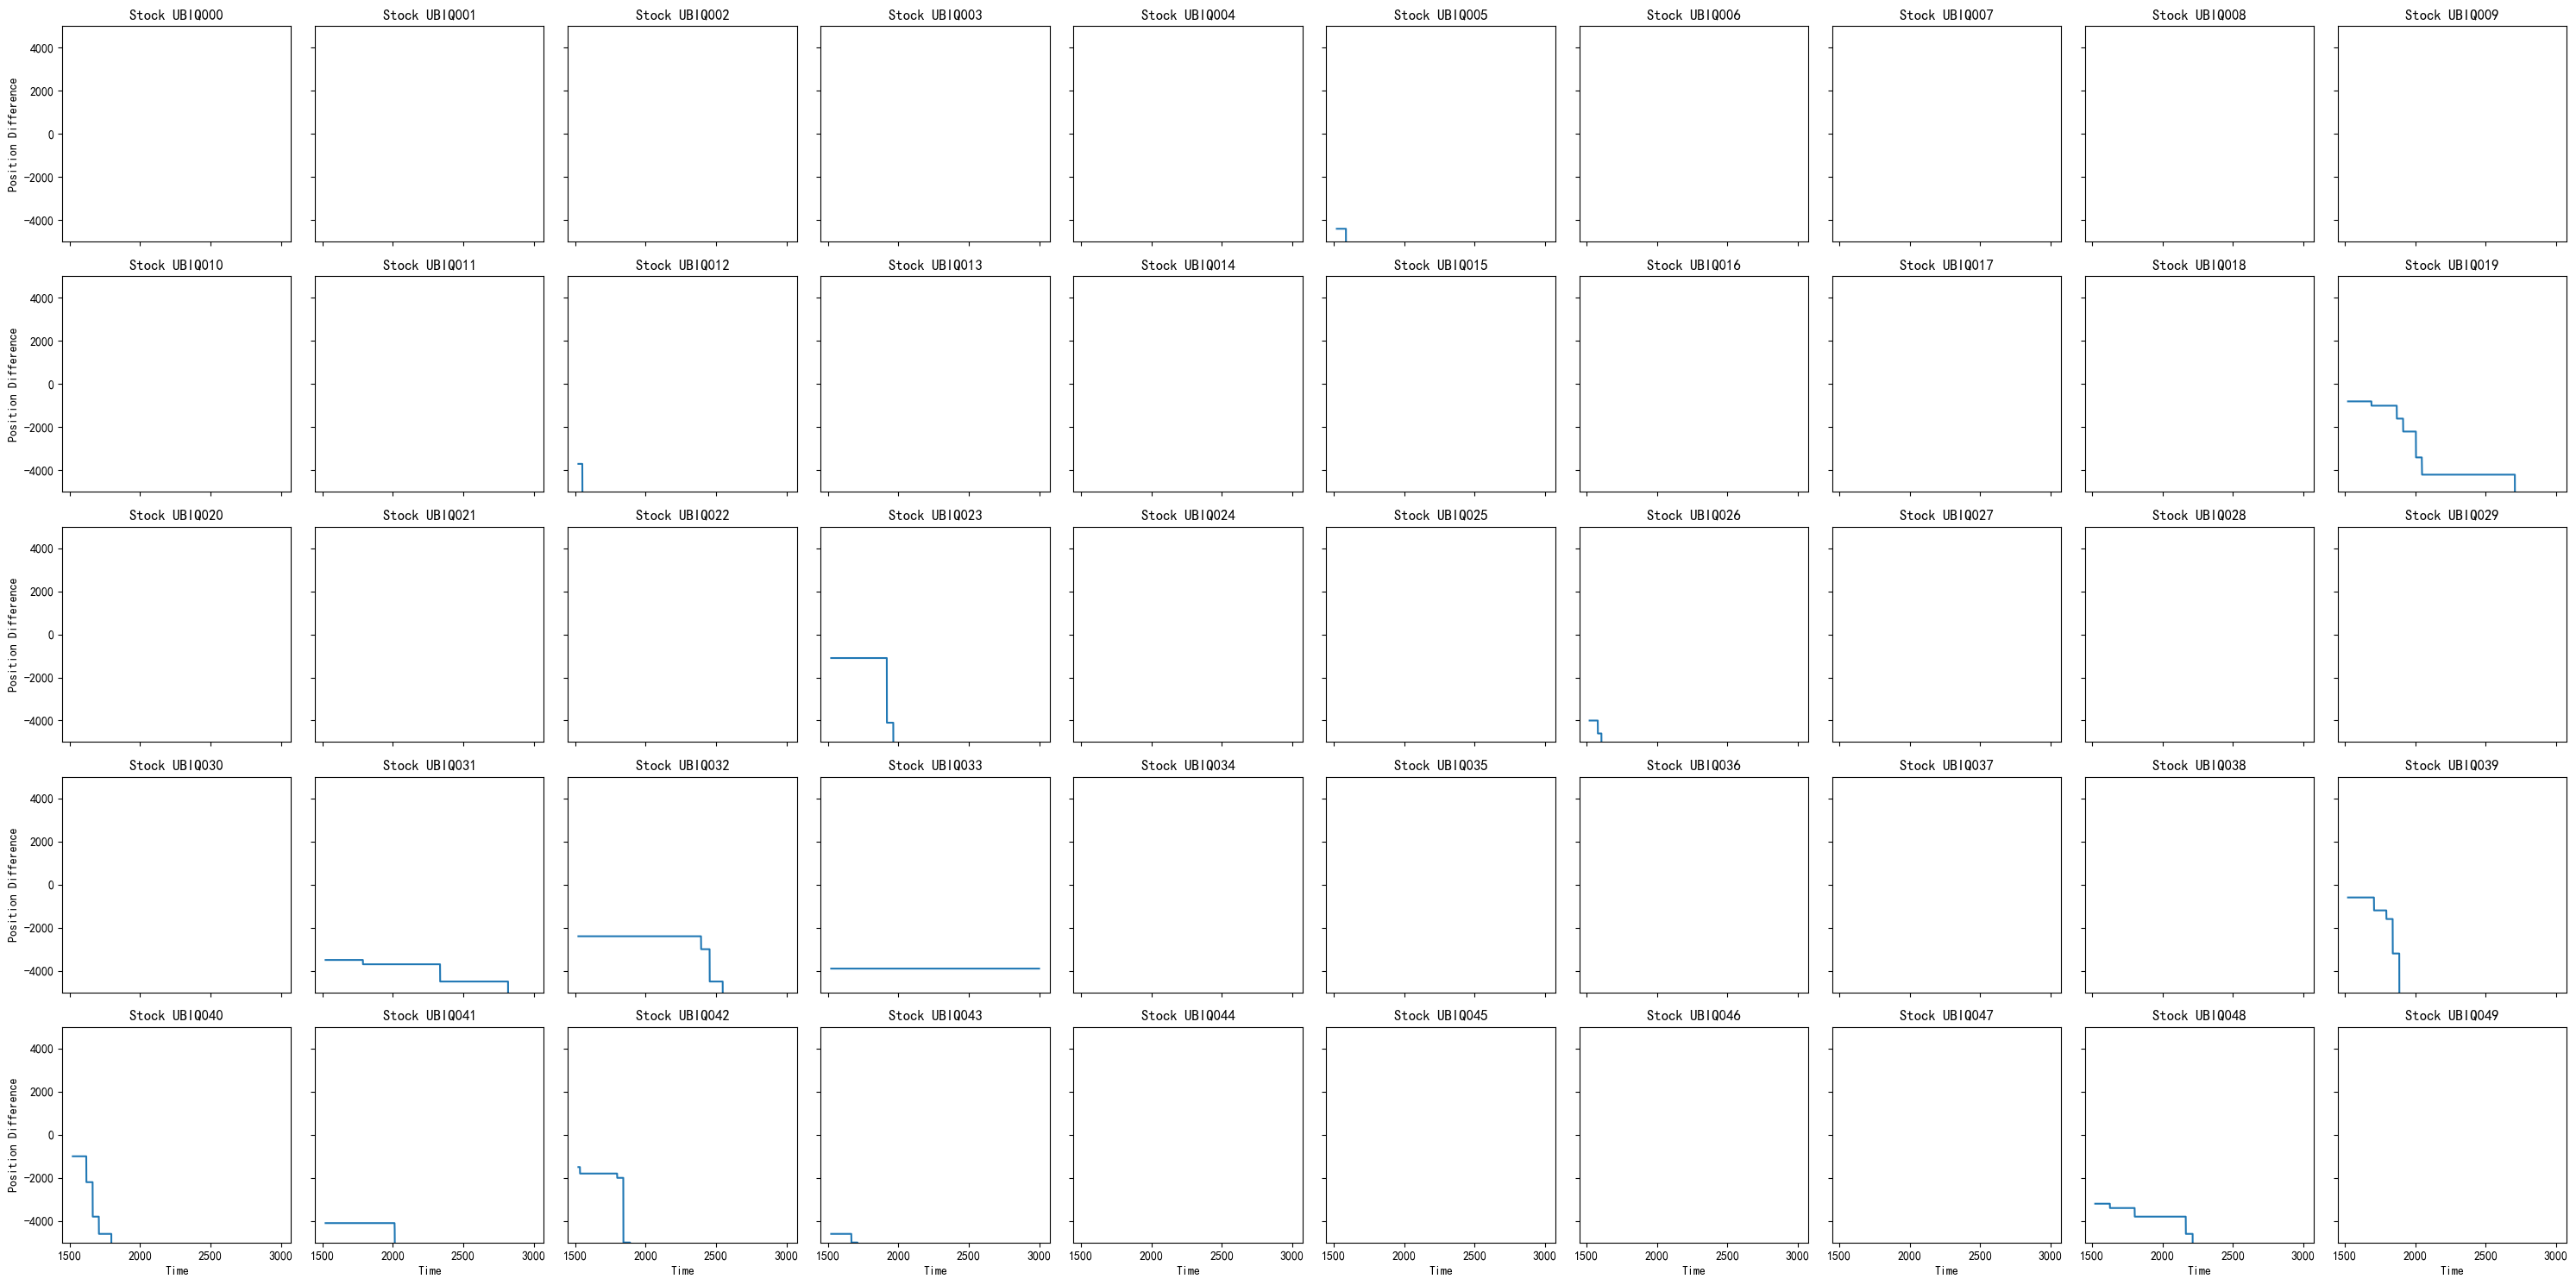

KeyError: 'Timestamp'

<Figure size 1200x600 with 0 Axes>

In [43]:
df = pd.read_csv('./snapshots/20240828-153024-day56_all_stocks.csv')

df['mid_price'] = (df['AskPrice1'] + df['BidPrice1']) / 2

# 分析RemainPositions和mid_price的相关性
def analyze_correlation(group):
    return pd.Series({
        'correlation': group['RemainPositions'].corr(group['mid_price']),
        'avg_remain_positions': group['RemainPositions'].mean(),
        'avg_mid_price': group['mid_price'].mean()
    })

correlation_results = df.groupby('StockID').apply(analyze_correlation)

# 可视化相关性
plt.figure(figsize=(12, 6))
sns.histplot(correlation_results['correlation'], kde=True)
plt.title('Distribution of Correlation between RemainPositions and mid_price')
plt.xlabel('Correlation')
plt.show()

# 分析RemainPositions和TargetPositions的差异
df['PositionDifference'] = df['RemainPositions'] - df['TargetPositions']

# 可视化每只股票的PositionDifference随时间的变化
fig, axes = plt.subplots(5, 10, figsize=(30, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, stock_id in enumerate(df['StockID'].unique()):
    stock_data = df[df['StockID'] == stock_id]
    axes[i].plot(stock_data['Tick'], stock_data['PositionDifference'])
    axes[i].set_title(f'Stock {stock_id}')
    axes[i].set_ylim(-5000, 5000)  # 调整y轴范围
    if i >= 40:
        axes[i].set_xlabel('Time')
    if i % 10 == 0:
        axes[i].set_ylabel('Position Difference')

plt.tight_layout()
plt.show()

# 分析交易量和交易价值
df['AvgTradePrice'] = df['TotalTradeValue'] / df['TotalTradeVolume']

# 可视化每只股票的累计交易量
plt.figure(figsize=(12, 6))
for stock_id in df['StockID'].unique():
    stock_data = df[df['StockID'] == stock_id]
    plt.plot(stock_data['Timestamp'], stock_data['TotalTradeVolume'].cumsum(), label=stock_id)

plt.title('Cumulative Trade Volume for Each Stock')
plt.xlabel('Time')
plt.ylabel('Cumulative Trade Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 分析价格波动
df['PriceChange'] = df.groupby('StockID')['mid_price'].diff()

# 可视化价格波动的分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='PriceChange', data=df)
plt.title('Distribution of Price Changes for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Price Change')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析交易活跃度
activity_by_stock = df.groupby('StockID')['TotalTradeVolume'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
activity_by_stock.plot(kind='bar')
plt.title('Total Trade Volume by Stock')
plt.xlabel('Stock ID')
plt.ylabel('Total Trade Volume')
plt.tight_layout()
plt.show()

# 分析买卖价差
df['Spread'] = df['AskPrice1'] - df['BidPrice1']

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='Spread', data=df)
plt.title('Distribution of Bid-Ask Spread for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Spread')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析深度
def calculate_depth(row):
    ask_depth = sum(row[f'AskVolume{i}'] for i in range(1, 11))
    bid_depth = sum(row[f'BidVolume{i}'] for i in range(1, 11))
    return (ask_depth + bid_depth) / 2

df['AverageDepth'] = df.apply(calculate_depth, axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='AverageDepth', data=df)
plt.title('Distribution of Average Order Book Depth for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Average Depth')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Analysis complete. Please review the generated plots for insights.")

In [ ]:
# 分析RemainPositions和TargetPositions的差异
df['PositionDifference'] = df['RemainPositions'] - df['TargetPositions']

# 可视化每只股票的PositionDifference随时间的变化
fig, axes = plt.subplots(5, 10, figsize=(30, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, stock_id in enumerate(df['StockID'].unique()):
    stock_data = df[df['StockID'] == stock_id]
    axes[i].plot(stock_data['Timestamp'], stock_data['PositionDifference'])
    axes[i].set_title(f'Stock {stock_id}')
    axes[i].set_ylim(-5000, 5000)  # 调整y轴范围
    if i >= 40:
        axes[i].set_xlabel('Time')
    if i % 10 == 0:
        axes[i].set_ylabel('Position Difference')

plt.tight_layout()
plt.show()

# 分析交易量和交易价值
df['AvgTradePrice'] = df['TotalTradeValue'] / df['TotalTradeVolume']

# 可视化每只股票的累计交易量
plt.figure(figsize=(12, 6))
for stock_id in df['StockID'].unique():
    stock_data = df[df['StockID'] == stock_id]
    plt.plot(stock_data['Timestamp'], stock_data['TotalTradeVolume'].cumsum(), label=stock_id)

plt.title('Cumulative Trade Volume for Each Stock')
plt.xlabel('Time')
plt.ylabel('Cumulative Trade Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 分析价格波动
df['PriceChange'] = df.groupby('StockID')['mid_price'].diff()

# 可视化价格波动的分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='PriceChange', data=df)
plt.title('Distribution of Price Changes for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Price Change')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析交易活跃度
activity_by_stock = df.groupby('StockID')['TotalTradeVolume'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
activity_by_stock.plot(kind='bar')
plt.title('Total Trade Volume by Stock')
plt.xlabel('Stock ID')
plt.ylabel('Total Trade Volume')
plt.tight_layout()
plt.show()

# 分析买卖价差
df['Spread'] = df['AskPrice1'] - df['BidPrice1']

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='Spread', data=df)
plt.title('Distribution of Bid-Ask Spread for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Spread')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析深度
def calculate_depth(row):
    ask_depth = sum(row[f'AskVolume{i}'] for i in range(1, 11))
    bid_depth = sum(row[f'BidVolume{i}'] for i in range(1, 11))
    return (ask_depth + bid_depth) / 2

df['AverageDepth'] = df.apply(calculate_depth, axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='AverageDepth', data=df)
plt.title('Distribution of Average Order Book Depth for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Average Depth')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Analysis complete. Please review the generated plots for insights.")